In [15]:
import pandas as pd
import scipy
import numpy as np
from math import sin, cos, pi, atan2, asin, sqrt
from scipy import integrate

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18, 'font.family':'times new roman'})
plt.rc('legend', fontsize=12)

In [16]:
################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m
ms2mph = 0.6818182*ft
gs2mph = ms2mph * 9.8

# Parameters
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = 3.1415
ft = 3.2884  # ft/m

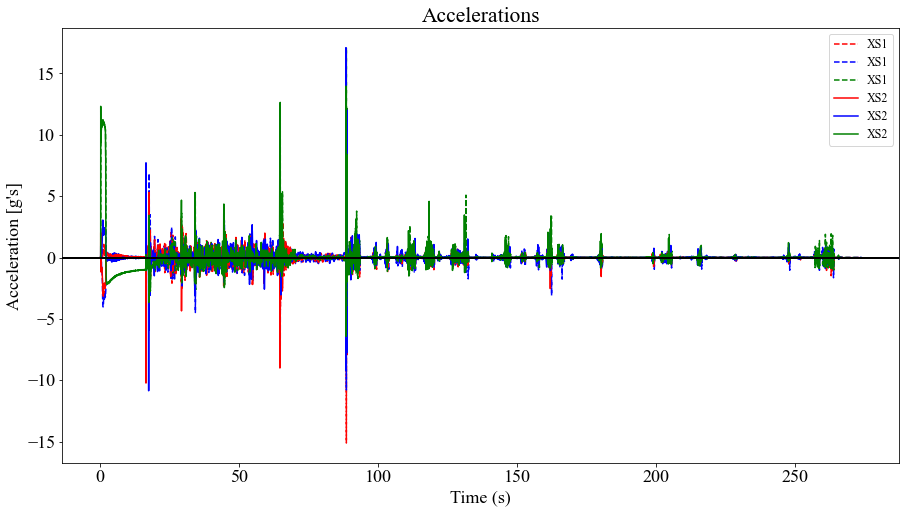

In [17]:
################## DATA FRAME ##################
datafile = 'Trunc_NASA_S1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
################## INIT VECTORS ##################
all_time1 = df['Timestamp'].values[190:]
tdata1 = all_time1
tdata1 = tdata1 - all_time1[0]
ax_g_S1 = df['LinearAccelNed X'][190:]/9.8
ay_g_S1 = df['LinearAccelNed Y'][190:]/9.8
az_g_S1 = df['LinearAccelNed Z'][190:]/-9.8

################## DATA FRAME ##################
datafile = 'Trunc_NASA_S2.csv'
df2 = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
################## INIT VECTORS ##################
all_time2 = df2['Timestamp'].values[200:]
tdata2 = all_time2
tdata2 = tdata2 - all_time2[0]
ax_g_S2 = df2['LinearAccelNed X'][200:]/9.8
ay_g_S2 = df2['LinearAccelNed Y'][200:]/9.8
az_g_S2 = df2['LinearAccelNed Z'][200:]/-9.8


fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tdata1, ax_g_S1, color='red', label='XS1', linestyle='--')
ax.plot(tdata1, ay_g_S1, color='blue', label='XS1', linestyle='--')
ax.plot(tdata1, az_g_S1, color='green', label='XS1', linestyle='--')
ax.plot(tdata2, ax_g_S2, color='red', label='XS2')
ax.plot(tdata2, ay_g_S2, color='blue', label='XS2')
ax.plot(tdata2, az_g_S2, color='green', label='XS2')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Accelerations")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
plt.show()

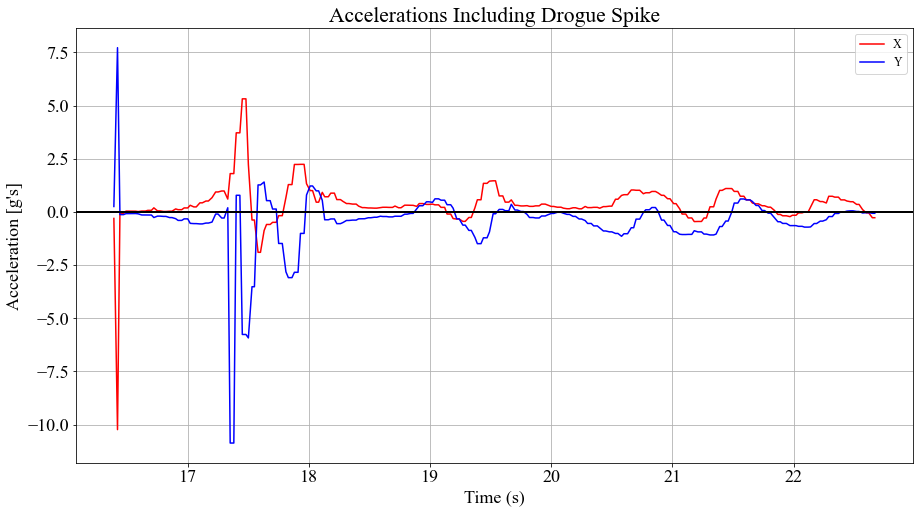

In [18]:
start_drogue_S2 = 890 - 220
end_drogue_S2 = 1100 - 310
tdata_S2 = tdata2[start_drogue_S2:end_drogue_S2]
axgt_S2 = list(ax_g_S2[start_drogue_S2:end_drogue_S2])

start_S2_with_spike = 850 - 200
end_S2_with_spike = 1100 - 200
tdata_S2_with_spike = tdata2[start_S2_with_spike:end_S2_with_spike]
axg_S2_with_spike = list(ax_g_S2[start_S2_with_spike:end_S2_with_spike])
ayg_S2_with_spike = list(ay_g_S2[start_S2_with_spike:end_S2_with_spike])
#tdata_S2_with_spike = tdata_S2_with_spike - tdata_S2_with_spike[0]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S2_with_spike, axg_S2_with_spike, color='red', label='X')
l2 = ax.plot(tdata_S2_with_spike, ayg_S2_with_spike, color='blue', label='Y')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Accelerations Including Drogue Spike")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.grid()
ax.legend()

plt.show()

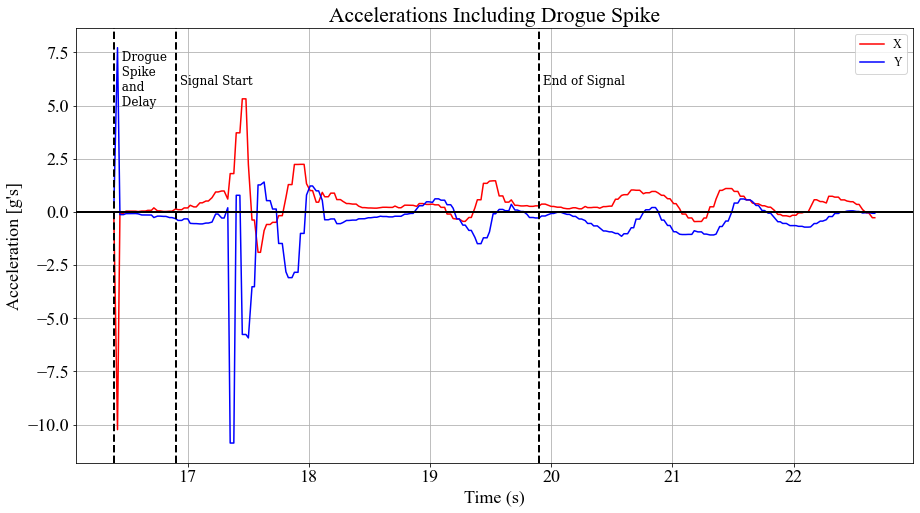

In [19]:
#fig1 = plt.figure(1, figsize=(600,100))
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S2_with_spike, axg_S2_with_spike, color='red', label='X')
l2 = ax.plot(tdata_S2_with_spike, ayg_S2_with_spike, color='blue', label='Y')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Accelerations Including Drogue Spike")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.grid()
ax.legend()

flight_phases = [('  Drogue\n  Spike\n  and\n  Delay', tdata2[start_S2_with_spike]), (' Signal Start', tdata2[start_drogue_S2]), (' End of Signal', tdata2[start_drogue_S2]+3)]
placement = [5, 6, 6]

for i, wavelength in enumerate(flight_phases):
        #print(wavelength[0], wavelength[1])
        ax.axvline(linewidth=2, color='black', linestyle='--', x=wavelength[1])
        plt.text(wavelength[1], # x-value from data
                 placement[i], # wiggle the labels 2so they don't overlap
                 wavelength[0], # string label
                 #transform = transDA,
                 color='black',
                 family='serif',
                 size=12) # the III looked better serif. 

plt.show()

In [20]:
def find_peak_and_wait(ax, t, thresh=4, delay=2):
    axn = np.array(ax)
    above_threshold = axn > thresh
    first_pass = list(above_threshold).index(True)
    print(f"First pass at index {first_pass} at time {t[first_pass]}")
    
    i = first_pass
    while t[i] < (t[first_pass] + 2):
        i += 1
    return first_pass


def calc_moving_avg(axg21t, n, tdata21, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80):        
    if dynamic_window:
        axg21s_1 = pd.Series(axg21t[0:dynamic_n_timing]).rolling(window=n).mean().iloc[n-1:].values
        axg21s_2 = pd.Series(axg21t).rolling(window=dynamic_n).mean().iloc[n-1:].values[dynamic_n_timing:]
        new_axg21s = list(axg21s_1) + list(axg21s_2)
    else:
        axg21s = pd.Series(axg21t).rolling(window=n).mean().iloc[n-1:].values
        new_axg21s = list(axg21s)
    while len(new_axg21s) < len(tdata21):
        new_axg21s = [0] + list(new_axg21s) + [0]
    return new_axg21s

In [21]:
print("SIFT 2")
ayg_S2_t = ay_g_S2[start_drogue_S2:end_drogue_S2]

dt2 = 0
for i in range(0, 100):
    dt2 += tdata_S2[i+1] - tdata_S2[i]
dt2 /= 100

#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ax_g_S2, 25, tdata_S2)
new_axg_25_S2 = axg21t[start_drogue_S2:end_drogue_S2]
axg21t = calc_moving_avg(ax_g_S2, 120, tdata_S2)
new_axg_65_S2 = axg21t[start_drogue_S2:end_drogue_S2]
#axg21t = calc_moving_avg(ax_g_S2, 15, tdata_S2)
#new_axg_15_S2 = axg21t[start_drogue_S2:end_drogue_S2]

ayg21t = calc_moving_avg(ay_g_S2, 15, tdata_S2)
new_ayg_25_S2 = ayg21t[start_drogue_S2:end_drogue_S2]
ayg21t = calc_moving_avg(ay_g_S2, 75, tdata_S2)
new_ayg_65_S2 = ayg21t[start_drogue_S2:end_drogue_S2]
ayg21t = calc_moving_avg(ay_g_S2, 15, tdata_S2)
new_ayg_15_S2 = ayg21t[start_drogue_S2:end_drogue_S2]

SIFT 2


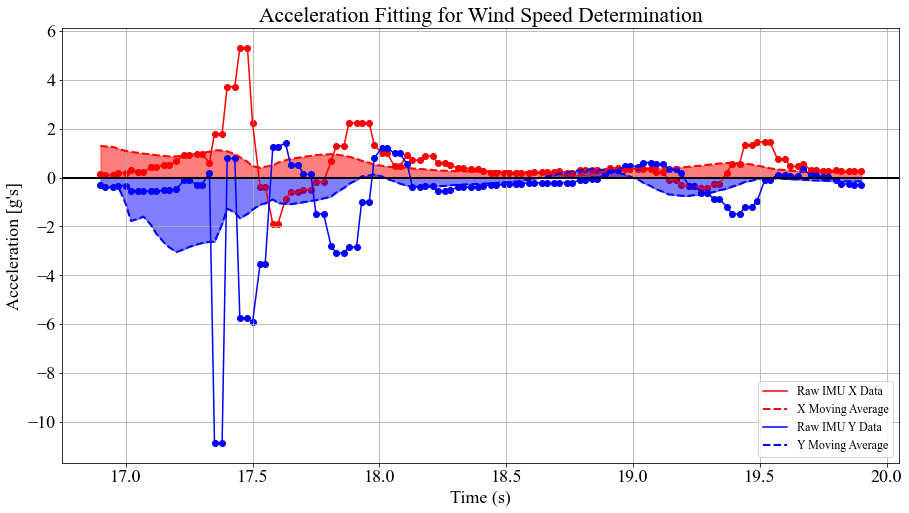

Estimated W0X via Moving Average (65): 27.50 mph
Estimated W0Y via Moving Average (25): -26.68 mph


In [22]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S2, ax_g_S2[start_drogue_S2:end_drogue_S2], color='red', label='Raw IMU X Data')
l2 = ax.scatter(tdata_S2, ax_g_S2[start_drogue_S2:end_drogue_S2], color='red')
l25 = ax.plot(tdata_S2, new_axg_25_S2, color='red', label='X Moving Average', linewidth=2, linestyle="--")
ax.fill_between(tdata_S2, new_axg_25_S2, color='red', alpha=0.5)

l2 = ax.plot(tdata_S2, ayg_S2_t, color='blue', label='Raw IMU Y Data')
l2 = ax.scatter(tdata_S2, ayg_S2_t, color='blue')
l25 = ax.plot(tdata_S2, new_ayg_25_S2, color='blue', label='Y Moving Average', linewidth=2, linestyle="--")
ax.fill_between(tdata_S2, new_ayg_25_S2, color='blue', alpha=0.5)

l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend(loc='lower right')
ax.grid()
plt.show()

result_trapz_MA65y = scipy.integrate.trapz(new_ayg_65_S2, dx=0.025)
result_trapz_MA65 = scipy.integrate.trapz(new_axg_65_S2, dx=dt2)
print(f"Estimated W0X via Moving Average (65): {gs2mph*result_trapz_MA65:.2f} mph")
print(f"Estimated W0Y via Moving Average (25): {gs2mph*result_trapz_MA65y:.2f} mph")

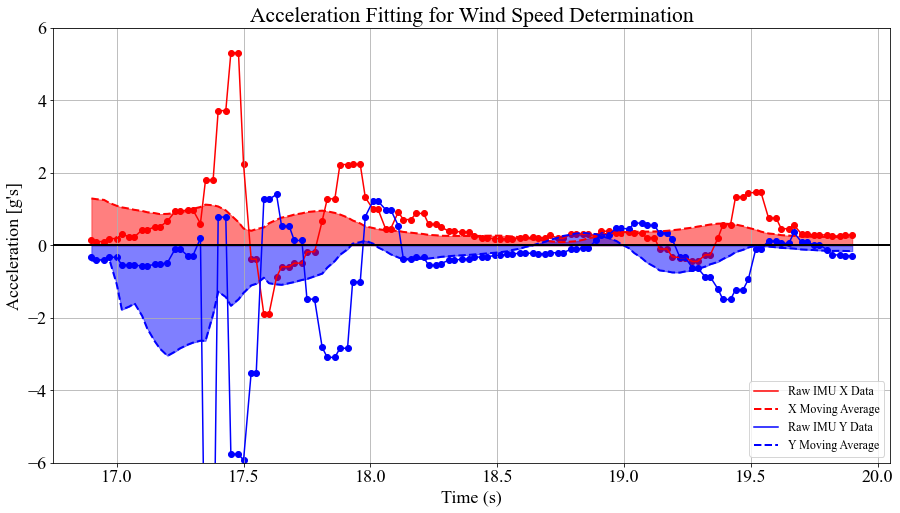

Estimated W0X via Moving Average (65): 27.50 mph
Estimated W0Y via Moving Average (25): -26.68 mph


In [23]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S2, ax_g_S2[start_drogue_S2:end_drogue_S2], color='red', label='Raw IMU X Data')
l2 = ax.scatter(tdata_S2, ax_g_S2[start_drogue_S2:end_drogue_S2], color='red')
l25 = ax.plot(tdata_S2, new_axg_25_S2, color='red', label='X Moving Average', linewidth=2, linestyle="--")
ax.fill_between(tdata_S2, new_axg_25_S2, color='red', alpha=0.5)

l2 = ax.plot(tdata_S2, ayg_S2_t, color='blue', label='Raw IMU Y Data')
l2 = ax.scatter(tdata_S2, ayg_S2_t, color='blue')
l25 = ax.plot(tdata_S2, new_ayg_25_S2, color='blue', label='Y Moving Average', linewidth=2, linestyle="--")
ax.fill_between(tdata_S2, new_ayg_25_S2, color='blue', alpha=0.5)

l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend(loc='lower right')
ax.grid()

ax.set_ylim((-6, 6))

plt.show()

result_trapz_MA65y = scipy.integrate.trapz(new_ayg_65_S2, dx=0.025)
result_trapz_MA65 = scipy.integrate.trapz(new_axg_65_S2, dx=dt2)
print(f"Estimated W0X via Moving Average (65): {gs2mph*result_trapz_MA65:.2f} mph")
print(f"Estimated W0Y via Moving Average (25): {gs2mph*result_trapz_MA65y:.2f} mph")

# 22 Full-Scale

In [24]:
################## DATA FRAME ##################
datafile = '../Data/Trunc_Fullscale1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]
L = tdata.shape[0]

ax_g22 = df['LinearAccelNed X']/9.8 #* ft
ay_g22 = df['LinearAccelNed Y']/9.8 #* ft
az_g22 = df['LinearAccelNed Z']/-9.8 #* -ft

start22 = 670
end22 = 900
tdata22 = tdata[start22:end22]
axg22t = list(ax_g22)[start22:end22]

Text(0, 0.5, "Acceleration [g's]")

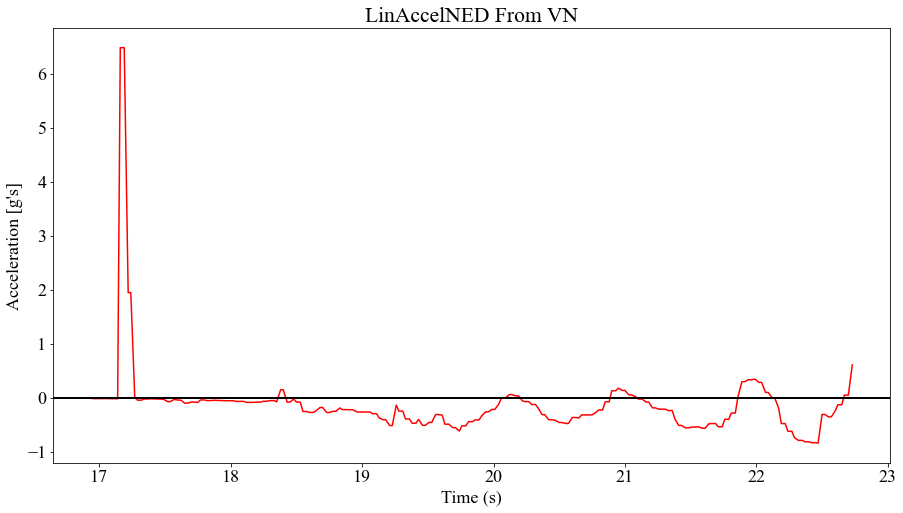

In [25]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata22, axg22t, color='red', label='x')
l2 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
#plt.ylim((-2, 2))

Text(0, 0.5, "Acceleration [g's]")

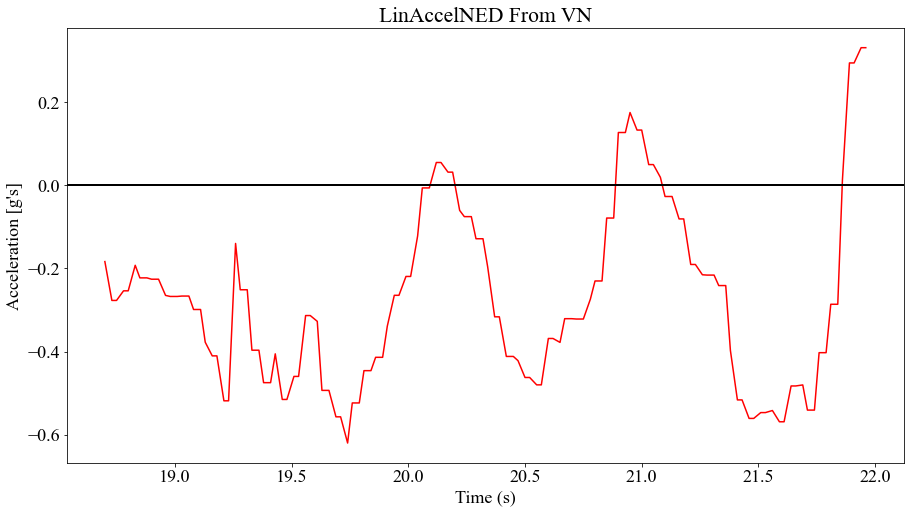

In [26]:
start22 = 740
end22 = 870
tdata22 = tdata[start22:end22]
axg22t = list(ax_g22)[start22:end22]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata22, axg22t, color='red', label='x')
l2 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
#plt.ylim((-2, 2))

In [27]:
ayg21t = calc_moving_avg(ay_g_S2, 25, tdata_S2)
new_ayg_25_S2 = ayg21t[start_drogue_S2:end_drogue_S2]
ayg21t = calc_moving_avg(ay_g_S2, 65, tdata_S2)
new_ayg_65_S2 = ayg21t[start_drogue_S2:end_drogue_S2]
ayg21t = calc_moving_avg(ay_g_S2, 15, tdata_S2)
new_ayg_15_S2 = ayg21t[start_drogue_S2:end_drogue_S2]

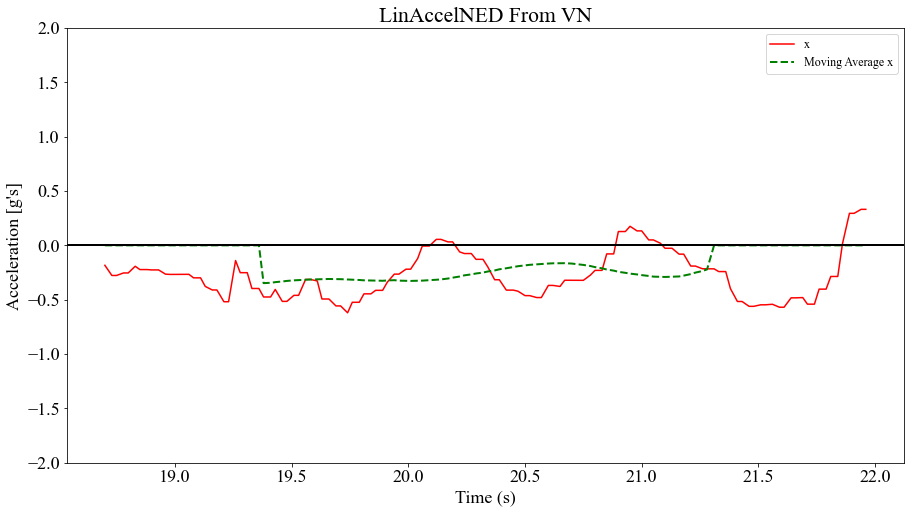

Estimated Wind Speed via Original IMU Signal: -8.73 m/s
Estimated Wind Speed via Moving Average: -5.01 m/s


In [28]:
n=55

#calculate moving average
axg22s = pd.Series(axg22t).rolling(window=n).mean().iloc[n-1:].values
new_axg22s = list(axg22s)
zero_padding_size = (len(tdata22) - len(list(axg22s))) // 2
for i in range(zero_padding_size):
    new_axg22s = [0] + list(new_axg22s) + [0]
while len(new_axg22s) < len(tdata22):
    new_axg22s = [0] + new_axg22s

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata22, ax_g22[start22:end22], color='red', label='x')
l2 = ax.plot(tdata22, new_axg22s, color='green', label='Moving Average x', linewidth=2, linestyle="--")
l2 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-2, 2))

ax.legend()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(ax_g22[start22:end22], dx=0.025)
result_trapz_MA = scipy.integrate.trapz(new_axg22s, dx=0.025)
#result_trapz_ZOOM = scipy.integrate.trapz(axg22t[75:280], dx=0.025)

print(f"Estimated Wind Speed via Original IMU Signal: {9.8*result_trapz_IMU:.2f} m/s")
print(f"Estimated Wind Speed via Moving Average: {9.8*result_trapz_MA:.2f} m/s")
#print(f"Estimated Wind Speed via Original, Zoomed In: {9.8*result_trapz_ZOOM:.2f} m/s")